# Working with Checkpointables

## Key Concepts

### Checkpoints as a Bundle

An Orbax checkpoint is not just a single, opaque unit. The checkpoint actually consists of a bundle of named objects. In this sense, the checkpoint is really more like a dictionary.

When you save a checkpoint using `ocp.save_pytree`, this produces a bundle with one key/value:

```
{
  'pytree': pytree
}
```

The PyTree is commonly used to represent an ML model state. However, there are other things we might want to include in the checkpoint, such as a dataset iterator, for example, which records the exact position in the data where training was interrupted. Now our bundle consists of two keys/values:

```
{
  'pytree': pytree,
  'dataset': dataset,
}
```

### The "Checkpointable" Concept

Each value in this bundle is called a "**checkpointable**", or to use the full term, a "**checkpointable object**".

 This refers to a logical piece of the checkpoint that is distinct in some way from other pieces. There is no hard and fast rule about what constitutes a checkpointable; it is somewhat up to user discretion. Here are a few guidelines, however:

 - Checkpointables are separable.
   - We often wish to load a strict subset of the available checkpointables, because certain checkpointables are not needed in certain contexts. For example, in training, we want to load the model state and dataset iterator, but the dataset iterator is not needed for evaluations.
   - Some checkpointables can be excluded entirely from the physical checkpoint without affecting the checkpoint's usefulness. For example, after training completes, the dataset iterator checkpointable is no longer useful, and we can just provide the model parameters to downstream consumers.
 - Checkpointables are often represented by different types, and have different representations on disk. For example, model parameters and optimizer states are represented as large partitioned tensors, while the dataset iterator checkpoint is a simple pointer to a position in the dataset iterator.
 - Checkpointables have few, if any, dependencies on other checkpointables within the same checkpoint. The model state can be loaded without the dataset iterator, and vice versa.

### Checkpointable vs. Abstract Checkpointable

A **checkpointable** is an object with some state that we want to save. A checkpointable may have a mirror image, an **abstract checkpointable** that is used to provide additional information used to guide how this state should be loaded back.

For example, consider an array. The array is a concrete object with real data that we want to save. It has properties like shape and dtype. When we load the array from disk, we don't necessarily need any extra information to do so. Orbax can just return the array data with the correct shape and dtype.

However, what if we would like to cast this array (and many others) to a different dtype while loading? This could save some memory, if we cast from e.g. `float64` to `float32`.

We can use an abstract form of the array to specify the properties we need for loading, including `shape` and `dtype`. It will specify `float32` instead of `float64`, which will inform the casting behavior. We can use the shape provided by the abstract array to perform validation, or even to pad / truncate the array during loading if necessary.

Sometimes, loading a checkpointable doesn't require additional information. For example, if we just want to load a string dictionary from a JSON file, customization is rarely needed (any necessary customization can be handled via global settings). As a result the abstract checkpointable would be `None` in this case.

To summarize, every checkpointable is a concrete object that we wish to save. Every checkpointable has a corresponding *abstract* representation (which may be None) that stores properties useful for restoring the original checkpointable.

This concept can also be illustrated with a diagram.

*   `save_checkpointables` accepts `Checkpointable` and saves it to a storage location.
*   `load_checkpointables` accepts `AbstractCheckpointable` (or None) loads it is a `Checkpointable` from the storage location.

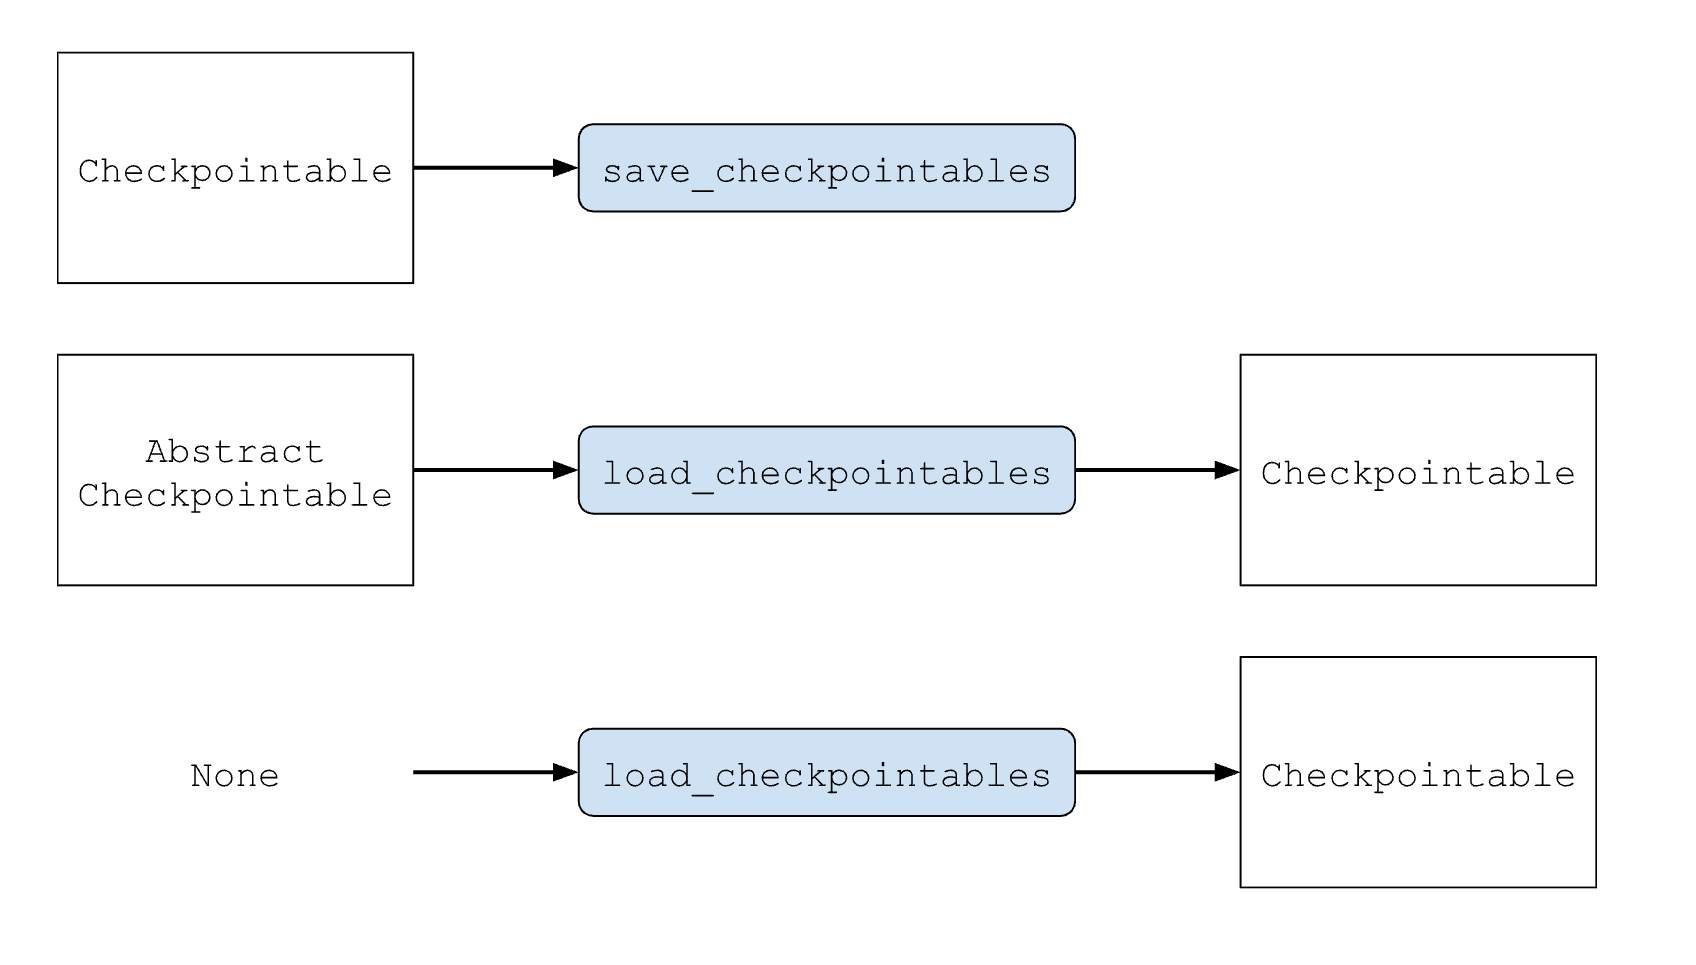

## Concrete Examples

Before beginning, let us note that all APIs demonstrated below have an equivalent function of the same name in `ocp.training.Checkpointer`, for use in the context of a training loop.

Let's take a look at some code examples, starting with some setup.

In [ ]:
### SETUP ###

import numpy as np
from orbax.checkpoint import v1 as ocp
from etils import epath
import jax

directory = epath.Path('/tmp/my-checkpoints')
mesh = jax.sharding.Mesh(jax.devices(), ('x',))
sharding = jax.sharding.NamedSharding(mesh, jax.sharding.PartitionSpec(None))

def fake_train_step(step: int):
  train_state = {
      'params': {
          'layer0': {
              'kernel': np.random.uniform(size=(2, 2)),
              'bias': np.ones(2),
          }
      },
      'opt_state': {
          '0': np.random.random(size=(2,))
      },
      'step': np.asarray(step),
  }
  return jax.tree.map(
      lambda arr: jax.make_array_from_callback(
          arr.shape,
          sharding,
          lambda idx: arr[idx],
      ),
      train_state,
  )

### Saving and Loading Multiple Checkpointables

Previously, we were only saving the train state, which was represeted as a PyTree of arrays.

In [ ]:
train_state = fake_train_step(0)
ocp.save_pytree(directory / 'just_pytree', train_state)

Now we can save the train state as well as a fake dataset. Ordinarily we would
use a real dataset iterator from a library like [Grain](https://google-grain.readthedocs.io/en/latest/index.html),
but let's just use a simple dictionary for an initial demonstration. See "Working with Real Datasets" below for a demonstration of real dataset checkpointing.

In [ ]:
train_state = fake_train_step(1)
ocp.save_checkpointables(
    directory / 'pytree_and_dataset', dict(pytree=train_state, dataset={'index': 2})
)

We can load the checkpointables, which returns a dict with the same keys as are contained in the checkpoint.

In [ ]:
ocp.load_checkpointables(directory / 'pytree_and_dataset')

### Interoperating with `save_pytree` / `load_pytree`



The APIs `save_pytree` and `load_pytree` interoperate with `save_checkpointables` and `load_checkpointables`. Recall that `save_pytree` just produces a special bundle where the only key is "pytree" and the only checkpointable is the PyTree object. Calling `load_pytree` will only load the key named `pytree`, regardless of what other checkpointables are present.

In [ ]:
ocp.load_pytree(directory / 'pytree_and_dataset')

In [ ]:
ocp.load_checkpointables(directory / 'just_pytree')

Note that we can give any names we want to our checkpointables.

In [ ]:
ocp.save_checkpointables(
    directory / 'train_state_and_dataset', dict(train_state=train_state, dataset={'index': 3})
)

These are still loadable as normal with `load_checkpointables`, but `load_pytree` will fail because there is no key named "pytree".

In [ ]:
ocp.load_checkpointables(directory / 'train_state_and_dataset')

In [ ]:
try:
  ocp.load_pytree(directory / 'train_state_and_dataset')
except BaseException as e:
  print(e)

### Partial Loading

As mentioned above, a key property of checkpointables is that they are easily separable. We should be able to restore only train_state or only dataset individually. We need to call load_checkpointables and specify that only the dataset key is desired.

In [ ]:
ocp.load_checkpointables(
    directory / 'train_state_and_dataset',
    dict(dataset=None),
)

Alternatively, we can use the same API to load the train state alone.

In [ ]:
ocp.load_checkpointables(
    directory / 'train_state_and_dataset',
    dict(train_state=None),
)

<div class="alert alert-block alert-warning">
<b>CAUTION</b> Manual manipulation of the checkpoint directory is generally RISKY and UNSUPPORTED. Once a checkpoint is written, it should not be manually modified, otherwise it risks becoming corrupted.
</div>

With that warning out of the way, there is one supported manual directory manipulation. You may delete subdirectories corresponding to specific checkpointables.

Concretely, this means that a checkpoint saved with checkpointables `dict(a=..., b=..., c=...)` will have subdirectories `a`, `b`, and `c`. It is legal to manually delete these subdirectories. The information contained therein will be lost, but remaining checkpointables will still be loadable.

In the example shown below, we can remove the subdirectory called `'dataset'`.

In [ ]:
(directory / 'train_state_and_dataset' / 'dataset').rmtree()
ocp.load_checkpointables(
    directory / 'train_state_and_dataset'
)

Obviously, attempting to load the dataset specifically will now fail.

In [ ]:
try:
  ocp.load_checkpointables(
    directory / 'train_state_and_dataset',
    {'dataset': None},
)
except BaseException as e:
  print(e)

### Understanding Abstract Checkpointables

Let's return to the examples shown just above:

```
ocp.load_checkpointables(
    directory / 'train_state_and_dataset',
    dict(dataset=None),
)
ocp.load_checkpointables(
    directory / 'train_state_and_dataset',
    dict(train_state=None),
)
```

What is the meaning of the syntax `dict(train_state=None)` or `dict(dataset=None)`?

We must recall the concept of abstract checkpointables from above. Just as `save_checkpointables` allows specifying a dictionary of checkpointables, `load_checkpointables` allows specifying a dictionary of *abstract* checkpointables.

In the example above, we specify `None` as the abstract checkpointable for `train_state`. `None` is always a valid value for an abstract checkpointable. It is equivalent to saying:

> *Restore this checkpointable exactly as it was saved - you don't need any additional information from me.*

So the pattern:

```
ocp.load_checkpointables(path, dict(checkpointable_name=None))
```

is an effective way of loading while filtering out only the keys that are desired.

Recall also that the abstract checkpointable for `train_state` may be something other than None. We know that `train_state` is a PyTree, so we just have to know what the abstract type of the PyTree is (it's also a PyTree). Then, for each leaf value in the state, we need to also specify a valid corresponding abstract leaf type. In this case, the leaves were all `jax.Array` originally, so the corresponding abstract type is `jax.ShapeDtypeStruct`.

In [ ]:
abstract_train_state = jax.tree.map(
  lambda arr: jax.ShapeDtypeStruct(arr.shape, arr.dtype, sharding=arr.sharding),
  train_state,
)
ocp.load_checkpointables(
    directory / 'train_state_and_dataset',
    dict(train_state=abstract_train_state),
)

More details on PyTrees, leaf types, and abstract leaf types can be found in Working with PyTrees TODO(b/411457158) add link.

### Working with Real Datasets

In our example above, we represented a "dataset" object as a simple dictionary. Let's use a real dataset iterator that we might use in a real training loop, namely [Grain](https://google-grain.readthedocs.io/en/latest/index.html).

In [ ]:
import grain

dataset = iter(
    grain.MapDataset.range(30)
    .batch(3)
    .map(lambda x: x.tolist())
)

In [ ]:
print(next(dataset))
print(next(dataset))
print(next(dataset))

In [ ]:
ocp.save_checkpointables(
    directory / 'train_state_and_grain', dict(train_state=train_state, dataset=dataset)
)

When we try to load by just passing the path, as we were able to do above, we get the following error:

In [ ]:
try:
  ocp.load_checkpointables(directory / 'train_state_and_grain')
except BaseException as e:
  print(e)

This means that in order to load Grain iterators (or any other object implementing `ocp.StatefulCheckpointable`), we must pass a "blank" or "uninitialized" instance of the object, which data from the checkpoint will be loaded into.

Let's create a new instance of the iterator starting at 0.

In [ ]:
new_dataset = iter(
    grain.MapDataset.range(30)
    .batch(3)
    .map(lambda x: x.tolist())
)

In [ ]:
loaded = ocp.load_checkpointables(
    directory / 'train_state_and_grain',
    dict(dataset=new_dataset),
)
print(next(loaded['dataset']))

After loading, `next` continues from the position we previously saved.

Note that the above loading code will only load the `dataset`, not the `train_state`, since we only requested that `dataset` be loaded. To load the `train_state` as well, pass `train_state` as an additional key, as shown in examples above.